In [12]:
#Grzegorz Jędrzejowski --Number--
print("Working!")

Working!


In [13]:
import sys
import os

#Set up your BDT_GJ directory location
my_BDT_directory_location = '/scratch/gjedrzej/WUM1/BDT_GJ'
sys.path.append(os.path.abspath(my_BDT_directory_location))

In [ ]:
#--> check at the end if you can run it on the fresh python (no preinstalls) after requirements on collab for example
requirements_path = os.path.join(my_BDT_directory_location, 'requirements.txt')

!pip install --upgrade pip #Pip 21.3+ is required
!pip install -r {requirements_path}

#you might need to restart the kernel after installing requirements

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split


import subscripts.readParquet as read
import subscripts.filter as filter
import subscripts.plotter as plotter

In [23]:
Paths = [os.path.join(my_BDT_directory_location, 'Run3_2022/et/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/'),
         os.path.join(my_BDT_directory_location, 'Run3_2022/mt/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/'),
         os.path.join(my_BDT_directory_location, 'Run3_2022/tt/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/')]

df_et = pd.DataFrame()
df_mt = pd.DataFrame()
df_tt = pd.DataFrame()

df_et = read.read_parquet(Paths[0])
df_mt = read.read_parquet(Paths[1])
df_tt = read.read_parquet(Paths[2])

df_et_filtered = filter.apply_selection(df_et)
df_mt_filtered = filter.apply_selection(df_mt)
df_tt_filtered = filter.apply_selection(df_tt)

Found 5 files in /scratch/gjedrzej/WUM1/BDT_GJ/Run3_2022/et/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/. Loading...
✅ Successfully loaded 17468 rows.
Found 15 files in /scratch/gjedrzej/WUM1/BDT_GJ/Run3_2022/mt/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/. Loading...


✅ Successfully loaded 73043 rows.
Found 5 files in /scratch/gjedrzej/WUM1/BDT_GJ/Run3_2022/tt/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/. Loading...
✅ Successfully loaded 20258 rows.


In [17]:
pd.set_option('display.max_columns', None)
df_et_filtered.head()

,event,run,lumi,charge_1,charge_2,pt_1,eta_1,phi_1,mass_1,pt_2,eta_2,phi_2,mass_2,os,dR,dphi,pt_tt,pt_vis,phi_vis,eta_vis,mt_1,mt_2,mt_lep,mt_tot,m_vis,met_pt,met_phi,met_covXX,met_covXY,met_covYY,met_dphi_1,met_dphi_2,trg_singleelectron,trg_et_cross,idDeepTau2018v2p5VSjet_2,idDeepTau2018v2p5VSmu_2,idDeepTau2018v2p5VSe_2,decayMode_2,decayModePNet_2,n_jets,n_bjets,mjj,jdeta,sjdphi,dijetpt,jpt_1,jeta_1,jphi_1,jpt_2,jeta_2,jphi_2,aco_e_pi,aco_e_rho,aco_e_a1_FASTMTT_MassConstraint,alphaAngle_e_pi_1,alphaAngle_e_pi_2,alphaAngle_e_rho_1,alphaAngle_e_rho_2,alphaAngle_e_a1_FASTMTT_MassConstraint_1,alphaAngle_e_a1_FASTMTT_MassConstraint_2,PV_x,PV_y,PV_z,PVBS_x,PVBS_y,PVBS_z,ip_x_1,ip_y_1,ip_z_1,ip_x_2,ip_y_2,ip_z_2,ip_LengthSig_1,ip_LengthSig_2,hasRefitSV_1,hasRefitSV_2,sv_x_1,sv_y_1,sv_z_1,sv_x_2,sv_y_2,sv_z_2,FastMTT_mass,FastMTT_pt,FastMTT_pt_1,FastMTT_pt_2,FastMTT_mass_constraint,FastMTT_pt_constraint,FastMTT_pt_1_constraint,FastMTT_pt_2_constraint,pi_pt_1,pi_eta_1,pi_phi_1,pi_mass_1,pi_charge_1,pi_pdgId_1,pi_Energy_1,pi2_pt_1,pi2_eta_1,pi2_phi_1,pi2_mass_1,pi2_charge_1,pi2_pdgId_1,pi2_Energy_1,pi3_pt_1,pi3_eta_1,pi3_phi_1,pi3_mass_1,pi3_charge_1,pi3_pdgId_1,pi3_Energy_1,pi0_pt_1,pi0_eta_1,pi0_phi_1,pi0_mass_1,pi0_charge_1,pi0_pdgId_1,pi0_Energy_1,pi_pt_2,pi_eta_2,pi_phi_2,pi_mass_2,pi_charge_2,pi_pdgId_2,pi_Energy_2,pi2_pt_2,pi2_eta_2,pi2_phi_2,pi2_mass_2,pi2_charge_2,pi2_pdgId_2,pi2_Energy_2,pi3_pt_2,pi3_eta_2,pi3_phi_2,pi3_mass_2,pi3_charge_2,pi3_pdgId_2,pi3_Energy_2,pi0_pt_2,pi0_eta_2,pi0_phi_2,pi0_mass_2,pi0_charge_2,pi0_pdgId_2,pi0_Energy_2,weight,genWeight,is_data,LHEReweightingWeight_SM,LHEReweightingWeight_PS,LHEReweightingWeight_MM,nLHEjets,npNLOjets,LHE_Vpt,wt_cp_sm,wt_cp_ps,wt_cp_mm,pion_E_split_1,pion_E_split_2,gen_boson_pT,gen_boson_mass,gen_boson_eta,gen_boson_phi,gen_taunus_pT,gen_taunus_phi,genPartFlav_1,genPartFlav_2,genPart_pt_1,genPart_eta_1,genPart_phi_1,genPart_pdgId_1,genPart_pt_2,genPart_eta_2,genPart_phi_2,genPart_pdgId_2,genVisTau_pt_1,genVisTau_eta_1,genVisTau_phi_1,genVisTau_mass_1,genVisTau_pt_2,genVisTau_eta_2,genVisTau_phi_2,genVisTau_mass_2,gen_decayMode_1,gen_decayMode_2,genIP_1_x,genIP_1_y,genIP_1_z,genIP_2_x,genIP_2_y,genIP_2_z,w_WJ_soup,w_DY_NLO_soup,iso_1,e_pass90_1,e_mva_score_1,abs_eta_1,BDT_pred_score,BDT_pred_class,BDT_raw_score_tau,BDT_raw_score_higgs,BDT_raw_score_fake
0,16391896,1,12045,-1,1,39.168385,-0.598999,-2.536133,7.539056e-07,49.778530,0.113815,0.753906,1.277344,True,3.076854,2.993146,25.183544,12.468427,1.237111,-1.217231,18.333662,85.142166,88.068680,123.860420,93.768723,37.447762,-2.052734,195.0,93.7500,125.75,-0.483398,2.806641,False,False,8,4,8,10,11,0,0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.00000,-9999.000000,-9999.000000,5.234073,NaN,3.076385,1.206437,0.819111,1.206437,NaN,1.206437,1.327962,0.103271,-0.017334,4.415771,0.101013,-0.015076,4.414307,0.002895,-0.002549,-0.001101,0.002543,-0.003241,0.003808,1.724609,2.201172,0.0,True,-9999.0,-9999.0,-9999.0,0.300049,0.170532,4.445312,127.593847,24.438345,72.534045,49.778530,126.428674,23.184218,71.215245,49.778530,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,30.312500,0.108582,0.767456,0.139570,1,211.0,30.491687,9.781250,0.113892,0.755859,0.13957,-1,-211.0,9.845746,9.695312,0.129822,0.709351,0.13957,1,211.0,9.778124,-9999.000000,-9999.000000,-9999.000000,0.13498,0.0,111.0,-9999.000000,1.0,54.6329,0.0,1.0,0.489014,0.175438,3,157,0.0,0.880757,1.097813,0.082132,-9999.0,-9999.000000,8.170824,124.999953,-2.034641,2.141535,16.794702,-2.526153,15,5,39.5000,-0.599609,-2.539062,11.0,59.125,0.117188,0.750000,-15.0,-9999.0,-9999.0,-9999.0,-9999.0,57.125,0.118164,0.750000,1.699219,-1.0,11.0,0.003690,-0.001971,-0.003023,0.002785,-0.003024,0.000880,1.0,1.0,0.091817,True,0.999999,0.598999,0.486806,1,0.063301,0.

In [18]:
#Prepare the data for XGBoost
#0 -> et, 1 -> mt, 2 -> tt
df_et_filtered['channel'] = 0
df_mt_filtered['channel'] = 1
df_tt_filtered['channel'] = 2

features = [
    'pt_1', 'eta_1', 'phi_1', 'mass_1', 
    'pt_2', 'eta_2', 'phi_2', 'mass_2', 
    'channel', 'met_pt', 'met_phi', 
    'met_covXX', 'met_covXY', 'met_covYY'
]

targets = ['genPart_pt_1', 'genPart_pt_2']

X_et = df_et_filtered[features]
Y_et = df_et_filtered[targets]

X_mt = df_mt_filtered[features]
Y_mt = df_mt_filtered[targets]

X_tt = df_tt_filtered[features]
Y_tt = df_tt_filtered[targets]

X_train_et, X_test_et, y_train_et, y_test_et = train_test_split(X_et, Y_et, test_size=0.2, random_state=42)
X_train_mt, X_test_mt, y_train_mt, y_test_mt = train_test_split(X_mt, Y_mt, test_size=0.2, random_state=42)
X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(X_tt, Y_tt, test_size=0.2, random_state=42)

In [19]:
#XGBoost

#inspect params for different outcomes
model_et = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    tree_method='hist', 
    objective='reg:squarederror',
    early_stopping_rounds=10
)

model_mt = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    tree_method='hist', 
    objective='reg:squarederror',
    early_stopping_rounds=10
)

model_tt = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    tree_method='hist', 
    objective='reg:squarederror',
    early_stopping_rounds=10
)

# Fit the model
model_et.fit(X_train_et, y_train_et, eval_set=[(X_test_et, y_test_et)], verbose=100)
model_mt.fit(X_train_mt, y_train_mt, eval_set=[(X_test_mt, y_test_mt)], verbose=100)
model_tt.fit(X_train_tt, y_train_tt, eval_set=[(X_test_tt, y_test_tt)], verbose=100)

[0]	validation_0-rmse:750.57898
[13]	validation_0-rmse:752.40596


[0]	validation_0-rmse:390.28711
[9]	validation_0-rmse:392.02367
[0]	validation_0-rmse:664.37816
[15]	validation_0-rmse:665.44953


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

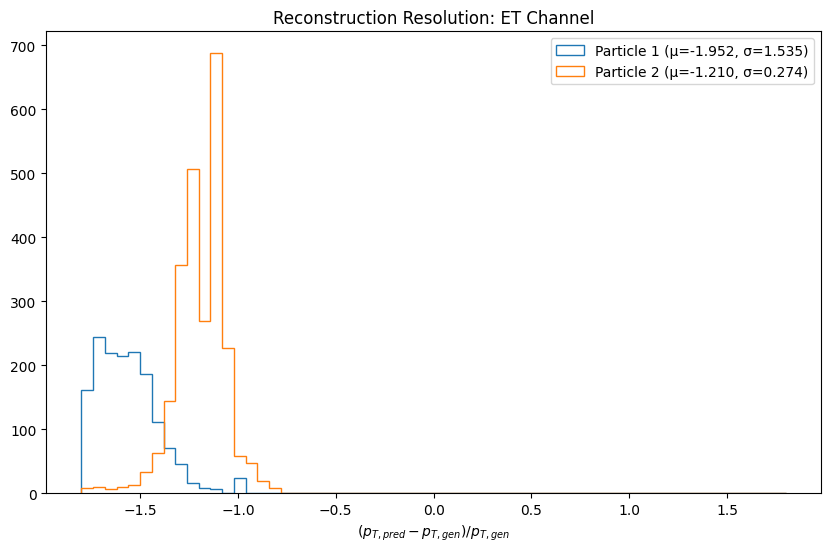

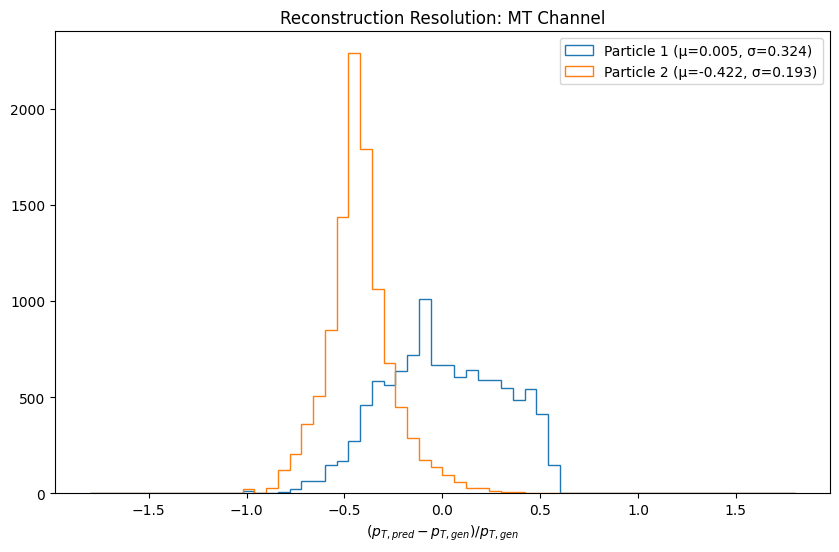

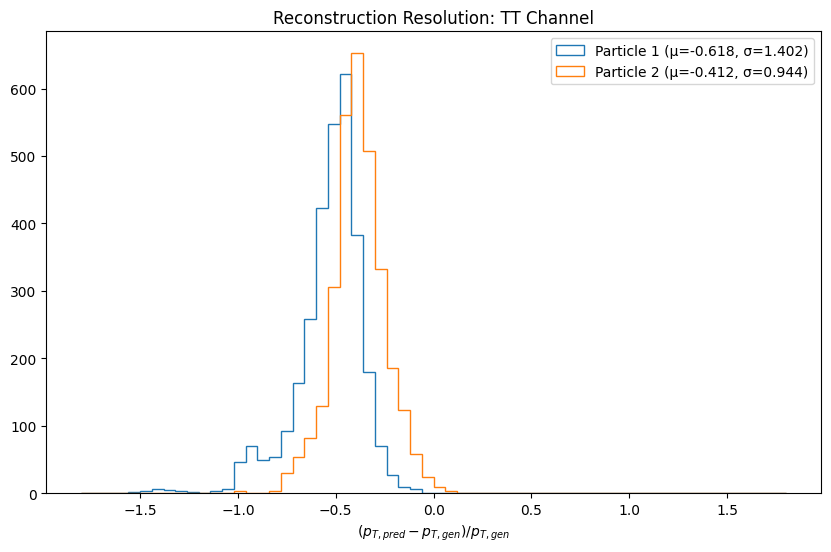

In [20]:
#Tree evaluation - ET channel
preds = model_et.predict(X_test_et)
plt.figure(figsize=(10, 6))
plotter.plot_physics_res(y_test_et['genPart_pt_1'], preds[:, 0], 'Particle 1')
plotter.plot_physics_res(y_test_et['genPart_pt_2'], preds[:, 1], 'Particle 2')
# plt.axvline(0, color='black', linestyle=':')
plt.xlabel(r'$(p_{T,pred} - p_{T,gen}) / p_{T,gen}$')
plt.title('Reconstruction Resolution: ET Channel')
plt.legend()
plt.show()


#Tree evaluation - MT channel
preds = model_mt.predict(X_test_mt)
plt.figure(figsize=(10, 6))
plotter.plot_physics_res(y_test_mt['genPart_pt_1'], preds[:, 0], 'Particle 1')
plotter.plot_physics_res(y_test_mt['genPart_pt_2'], preds[:, 1], 'Particle 2')
# plt.axvline(0, color='black', linestyle=':')
plt.xlabel(r'$(p_{T,pred} - p_{T,gen}) / p_{T,gen}$')
plt.title('Reconstruction Resolution: MT Channel')
plt.legend()
plt.show()


#Tree evaluation - TT channel
preds = model_tt.predict(X_test_tt)
plt.figure(figsize=(10, 6))
plotter.plot_physics_res(y_test_tt['genPart_pt_1'], preds[:, 0], 'Particle 1')
plotter.plot_physics_res(y_test_tt['genPart_pt_2'], preds[:, 1], 'Particle 2')
# plt.axvline(0, color='black', linestyle=':')
plt.xlabel(r'$(p_{T,pred} - p_{T,gen}) / p_{T,gen}$')
plt.title('Reconstruction Resolution: TT Channel')
plt.legend()
plt.show()



<Axes: title={'center': 'TT'}, xlabel='F score', ylabel='Features'>

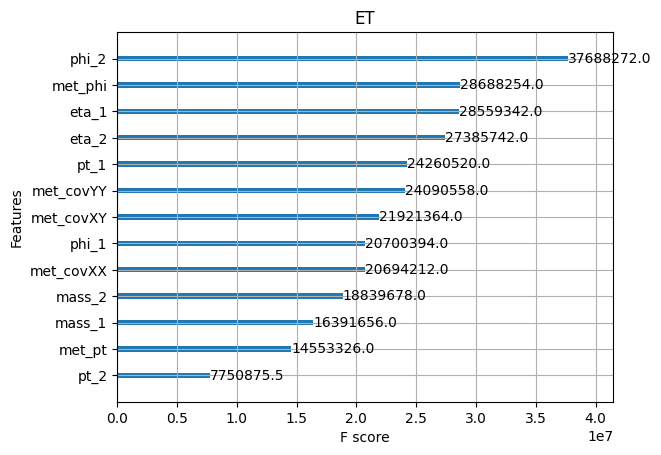

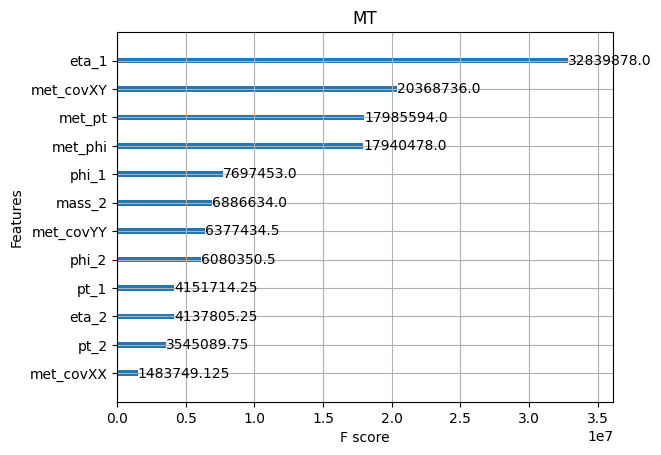

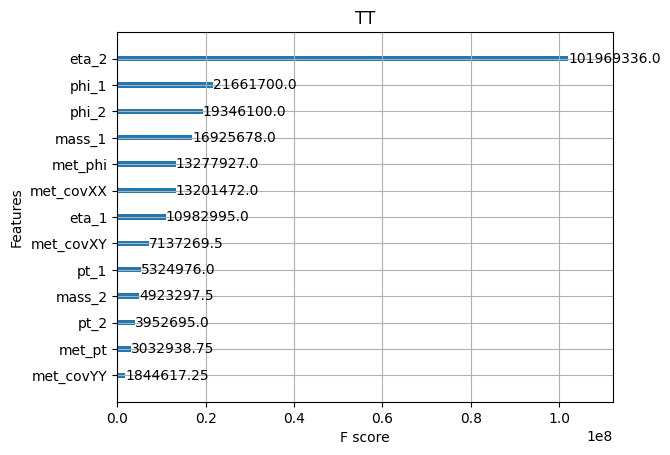

In [21]:
# 'gain' shows which feature improves the pT prediction the most
xgb.plot_importance(model_et, importance_type='gain', title='ET')
xgb.plot_importance(model_mt, importance_type='gain', title='MT')
xgb.plot_importance(model_tt, importance_type='gain', title='TT')

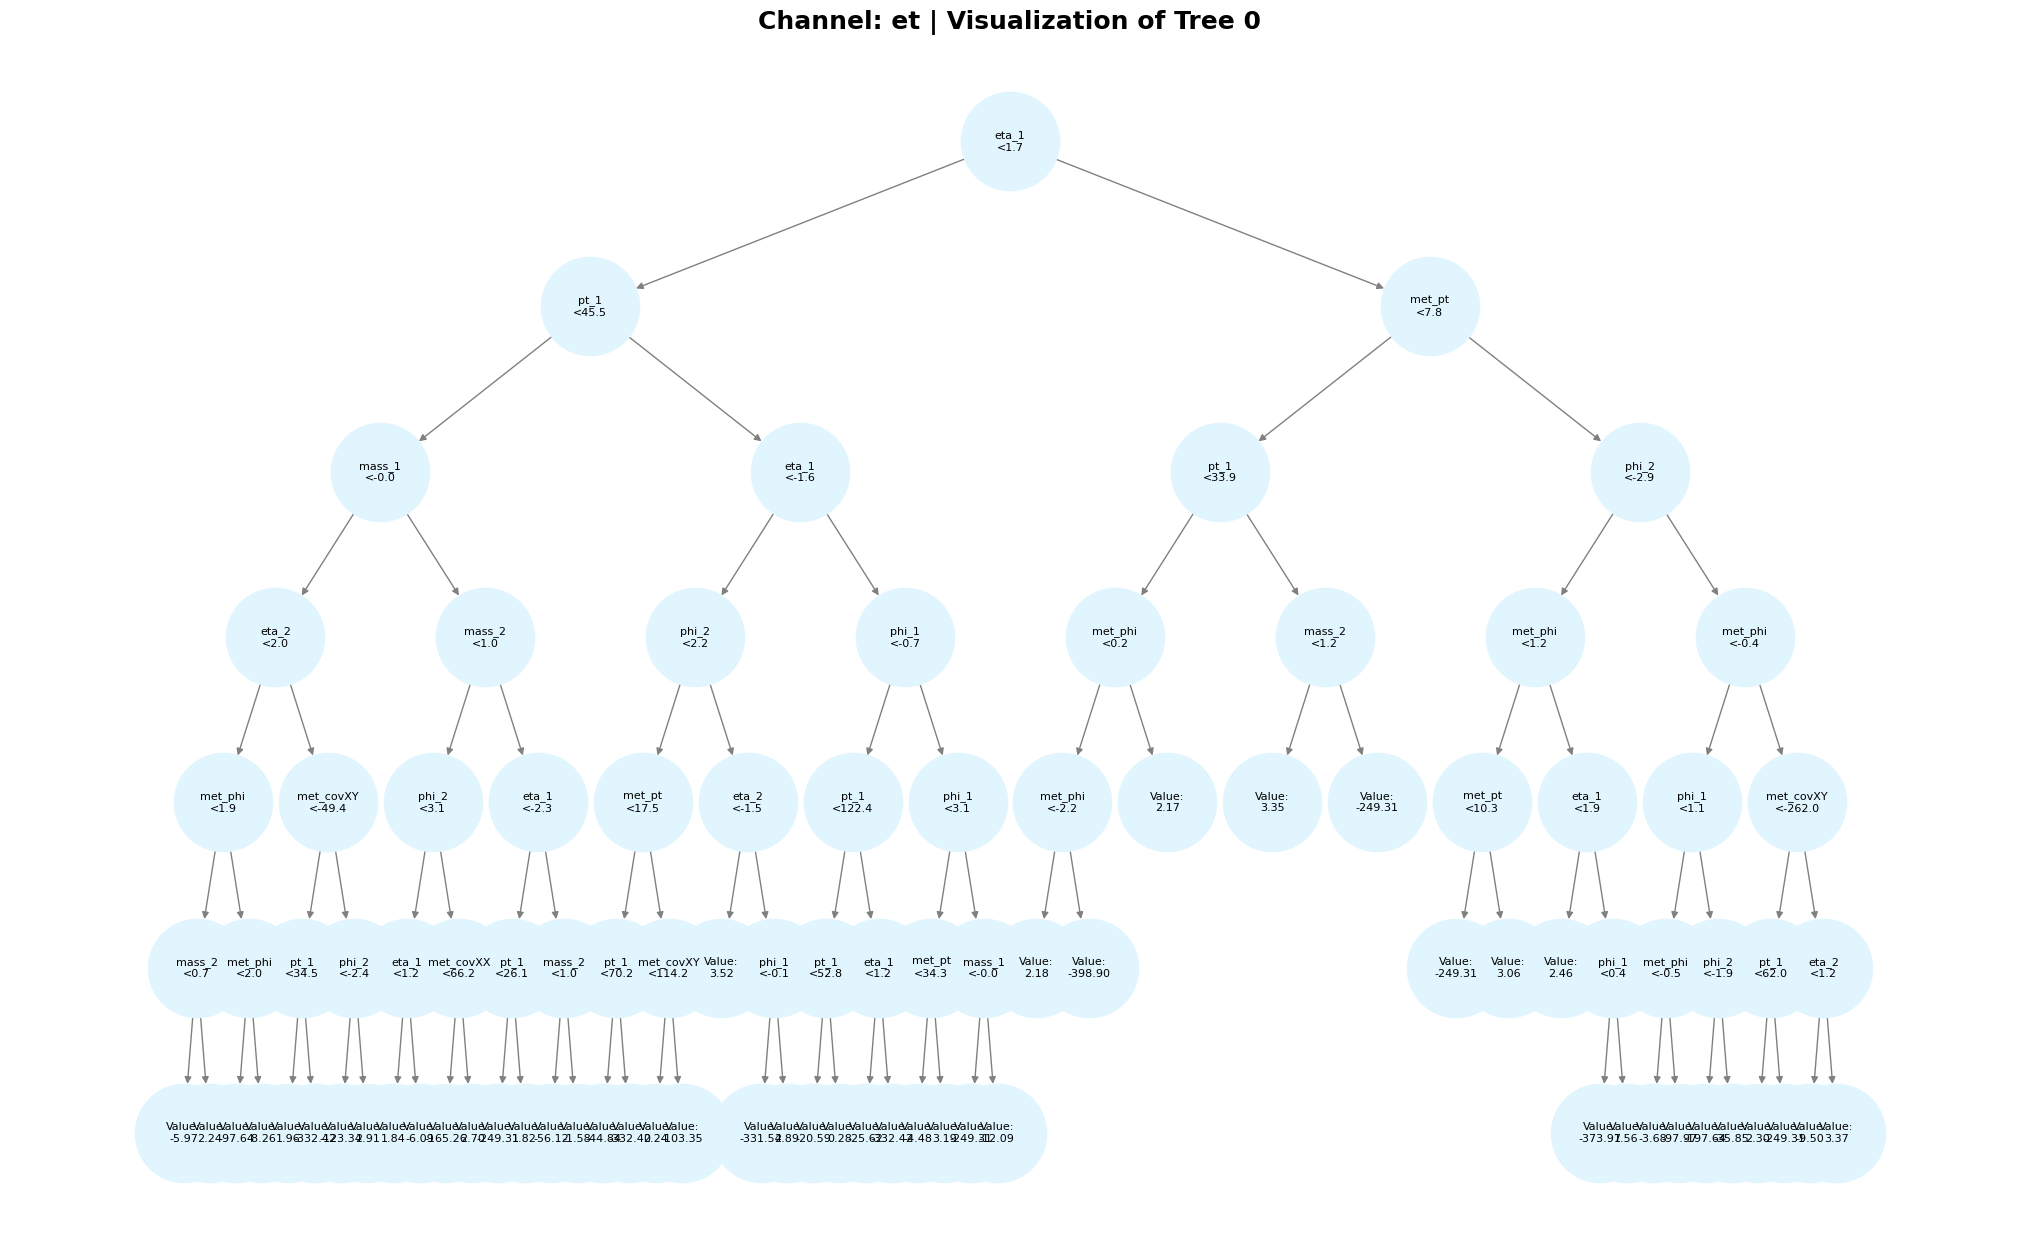

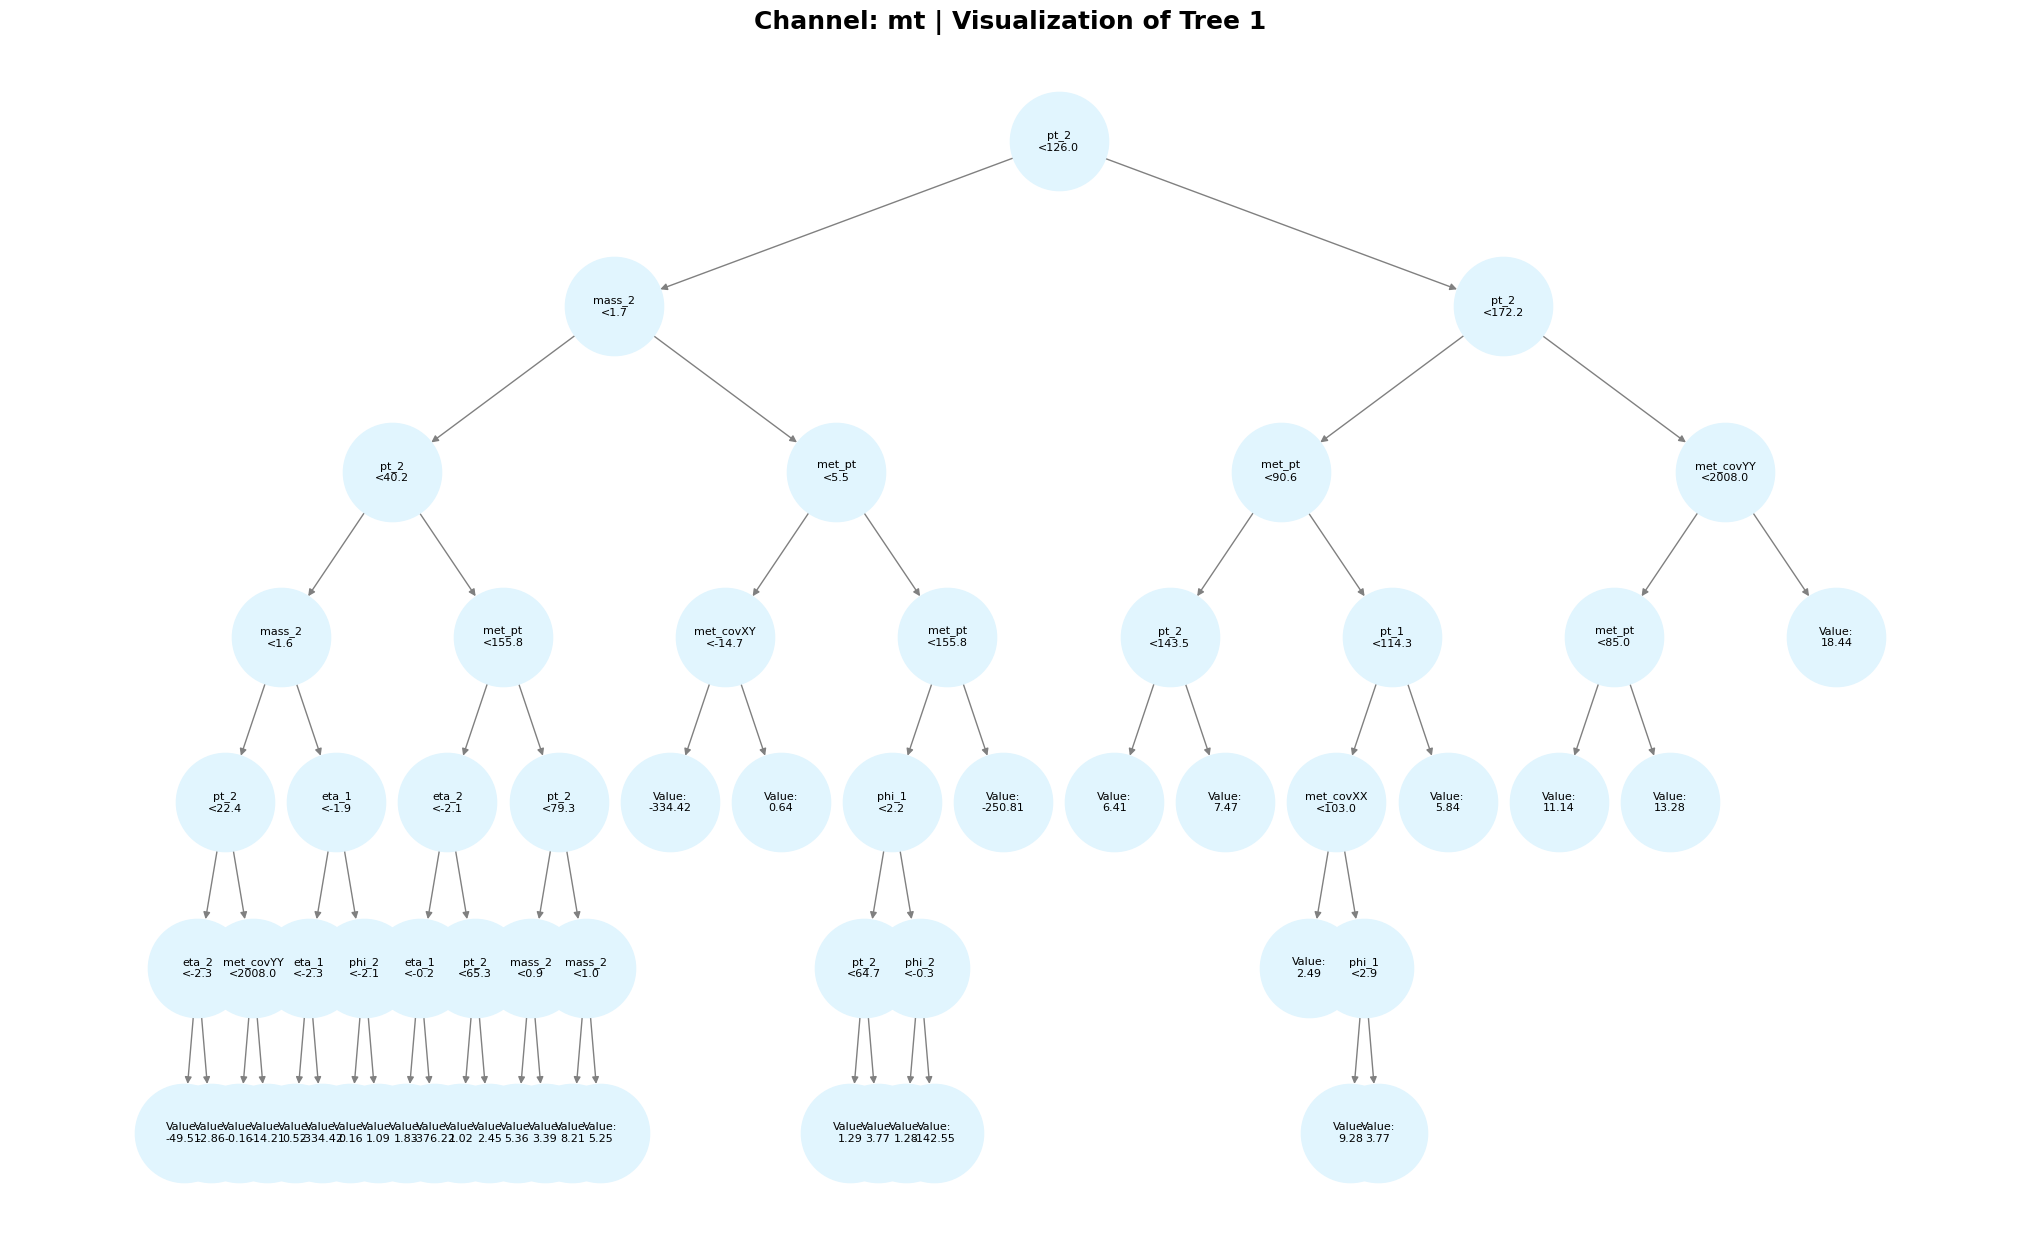

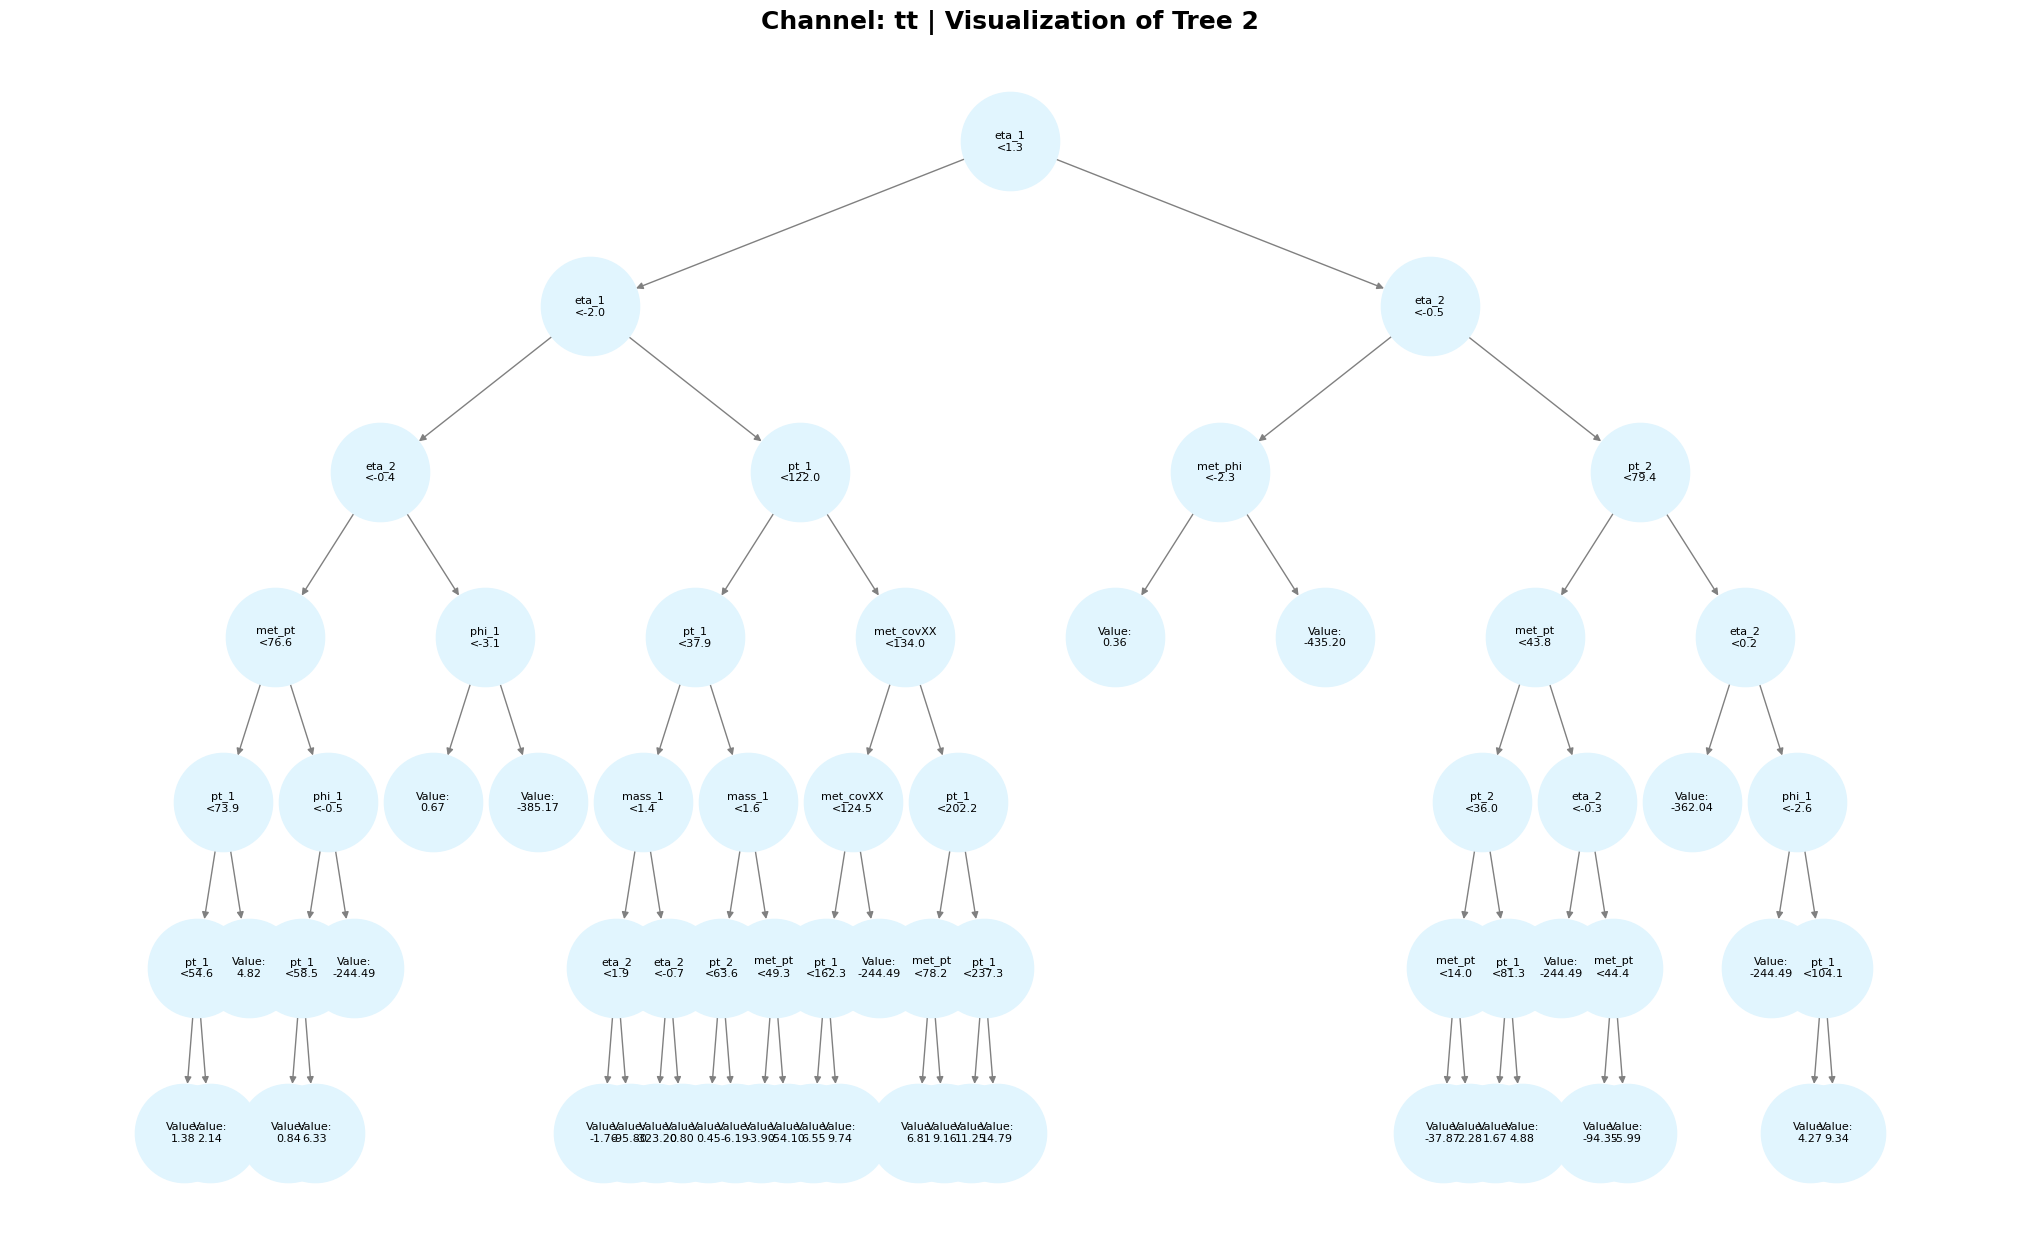

In [22]:
plotter.plot_clean_tree(model_et, tree_idx=0)
plotter.plot_clean_tree(model_mt, tree_idx=1)
plotter.plot_clean_tree(model_tt, tree_idx=2)